Loading FastText model...
Generating embeddings for full dataset...


100%|██████████| 18082/18082 [00:00<00:00, 39237.64it/s]


Before SMOTE: Counter({3: 6499, 4: 5227, 1: 3776, 2: 1489, 0: 1091})
After SMOTE: Counter({3: 6499, 2: 6499, 0: 6499, 4: 6499, 1: 6499})
Train-Test Split Done.
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time= 1.1min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.4min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time= 1.4min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time= 1.1min
[CV] END max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time= 1.1min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 1.5min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2

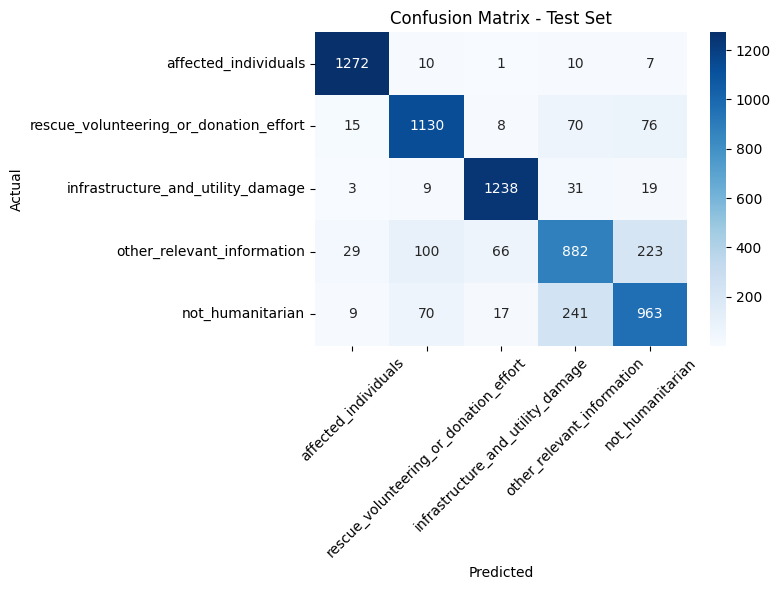

In [21]:
import pandas as pd
import numpy as np
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import gensim.downloader as api
from tqdm import tqdm
from collections import Counter

# ========== Load Dataset ==========
file_path = "/kaggle/input/mergefile/Merged_Disasters(2).csv"
df = pd.read_csv(file_path)
df.columns = df.columns.str.strip().str.lower()

# ========== Label Mapping ==========
label_map = {
    'affected_individuals': 0,
    'rescue_volunteering_or_donation_effort': 1,
    'infrastructure_and_utility_damage': 2,
    'other_relevant_information': 3,
    'not_humanitarian': 4
}

# ========== Preprocess Labels ==========
df['humanitarian_class'] = df['humanitarian_class'].fillna('not_humanitarian').str.strip().str.lower()
df['processed_data'] = df['processed_data'].fillna("")

# ========== Load FastText ==========
print("Loading FastText model...")
fasttext_model = api.load("fasttext-wiki-news-subwords-300")
embedding_dim = 300

# ========== FastText Embedding Function ==========
def get_avg_embedding(text, model, dim=300):
    words = text.split()
    embeddings = [model[word] for word in words if word in model.key_to_index]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(dim)

# ========== Generate Embeddings for Full Dataset ==========
print("Generating embeddings for full dataset...")
X_embed = np.vstack([get_avg_embedding(text, fasttext_model, embedding_dim) for text in tqdm(df['processed_data'])])

# ========== Additional Features ==========
df['tweet_length'] = df['processed_data'].apply(len)
df['num_hashtags'] = df['processed_data'].apply(lambda x: x.count("#"))
df['num_mentions'] = df['processed_data'].apply(lambda x: x.count("@"))

scaler = StandardScaler()
X_features = scaler.fit_transform(df[['tweet_length', 'num_hashtags', 'num_mentions']])

# ========== Combine Embeddings and Features ==========
X_full = np.hstack((X_embed, X_features))
y_full = df['humanitarian_class'].map(label_map).astype(int)

# ========== Apply SMOTE Before Splitting ==========
print("Before SMOTE:", Counter(y_full))
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_full, y_full)
print("After SMOTE:", Counter(y_balanced))

# ========== Train-Test Split After SMOTE ==========
X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.20, stratify=y_balanced, random_state=42
)
print("Train-Test Split Done.")

# ========== Hyperparameter Tuning ==========
param_dist = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=10, cv=3,
    scoring='accuracy', n_jobs=-1, verbose=2, random_state=42
)
random_search.fit(X_train, y_train)

# ========== Best Model ==========
best_rf = random_search.best_estimator_
print("Best RandomForest Parameters:", random_search.best_params_)

# ========== Final Training ==========
best_rf.fit(X_train, y_train)

# ========== Save Model ==========
joblib.dump(best_rf, "/kaggle/working/random_forest_best.pkl")
print("✅ Model saved as random_forest_best.pkl.")

# ========== Predictions & Evaluation ==========
y_pred = best_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
report = classification_report(y_test, y_pred, target_names=label_map.keys())

print("\n📊 Final Evaluation Summary:")
print(f"✅ Accuracy   : {acc:.4f}")
print(f"✅ F1 Score   : {f1:.4f}")
print("✅ Classification Report:\n", report)

# ========== Confusion Matrix ==========
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_map.keys(), yticklabels=label_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
